# Homework 3
## Introduction to Signal and Image Processing

Thibault Schowing
thibault.schowing@unfir.ch
thibault.schowing.student@unibe.ch

# Exercise 1


In [ ]:
import sys
import matplotlib
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import feature, color
import time


from scipy import ndimage as ndi

# To display plots inline
%matplotlib inline
##############################################################################
#                        Functions to complete                               #
##############################################################################
# Just a function to show an image, for debug purpose mainly
def show(img, name = "Some image"):
    plt.imshow(img)
    plt.axis('off')
    plt.title(name)
    plt.show()

################
# EXERCISE 1.1 #
################


def edge_map(img, sigma=10):
    # Returns the edge map of a given image.
    #
    # Inputs:
    #   img: image of shape (n, m, 3) or (n, m)
    #
    # Outputs:
    #   edges: the edge map of image
    
    if len(img.shape) == 3:
        img = color.rgb2gray(img)
    
    return feature.canny(img, sigma)


################
# EXERCISE 1.2 #
################


def fit_line(points):
    # Fits a line y=m*x+c through two given points (x0,y0) and
    # (x1,y1). Returns the slope m and the y-intersect c of the line.
    #
    # Inputs:
    #   points: list with two 2D-points [[x0,y0], [x1,y1]]
    #           where x0,y0,x0,y1 are integers
    #
    # Outputs:
    #   m: the slope of the fitted line, integer
    #   c: the y-intersect of the fitted line, integers
    #
    # WARNING: vertical and horizontal lines should be treated differently
    #          here add some noise to avoid division by zero.
    #          You could use for example sys.float_info.epsilon

    x0,x1,y0,y1 = points.flatten()
    h = (x0-x1)
    if h == 0:
        h += sys.float_info.epsilon
    
    m = (y0 - y1)/h
    c = (x0 * y1 - x1 * y0)/h

    return m, c


################
# EXERCISE 1.3 #
################


def point_to_line_dist(m, c, x0, y0):
    # Returns the minimal distance between a given
    #  point (x0,y0)and a line y=m*x+c.
    #
    # Inputs:
    #   x0, y0: the coordinates of the points
    #   m, c: slope and intersect of the line
    #
    # Outputs:
    #   dist: the minimal distance between the point and the line.
    
    return abs((m*x0)-y0+c)/math.sqrt((m**2)+1)
    


##############################################################################
#                           Main script starts here                          #
##############################################################################
start = time.time()
print("start") # to measure execution time
# Note: uncomment the picture to analyse
#filename = './img/synthetic.jpg' # sigma = 10
#filename = './img/bridge.jpg' # sigma = 5
filename = './img/pool.jpg' # sigma = 6
#filename = './img/tennis.jpg' # sigma = 5

image = plt.imread(filename)

# Chose the sigma !! (added as default to 10)
sigma = 6
edges = edge_map(image, sigma)

plt.imshow(edges)
plt.title('edge map')
plt.show()

edge_pts = np.array(np.nonzero(edges), dtype=float).T
edge_pts_xy = edge_pts[:, ::-1]

ransac_iterations = 500
ransac_threshold = 2
n_samples = 2

ratio = 0

# perform RANSAC iterations
for it in range(ransac_iterations):

    # this shows progress -> this slows everything down
    #sys.stdout.write('\r')
    #sys.stdout.write('iteration {}/{}'.format(it+1, ransac_iterations))
    #sys.stdout.flush()

    all_indices = np.arange(edge_pts.shape[0])
    np.random.shuffle(all_indices)

    indices_1 = all_indices[:n_samples]
    indices_2 = all_indices[n_samples:]

    maybe_points = edge_pts_xy[indices_1, :]
    test_points = edge_pts_xy[indices_2, :]

    # find a line model for these points
    m, c = fit_line(maybe_points)

    x_list = []
    y_list = []
    num = 0

    # find distance to the model for all testing points
    for ind in range(test_points.shape[0]):

        x0 = test_points[ind, 0]
        y0 = test_points[ind, 1]

        # distance from point to the model
        dist = point_to_line_dist(m, c, x0, y0)

        # check whether it's an inlier or not
        if dist < ransac_threshold:
            num += 1

    # in case a new model is better - cache it
    if num / float(n_samples) > ratio:
        ratio = num / float(n_samples)
        model_m = m
        model_c = c

x = np.arange(image.shape[1])
y = model_m * x + model_c

if m != 0 or c != 0:
    plt.plot(x, y, 'r')


plt.imshow(image)
plt.savefig(filename + "result.jpg")
plt.show()

end = time.time()
print("Time elapsed: ")
print(end - start)

# Exercise 2

Number of pixels remaining =  3473
88562.0 123520.0
110528.0 133523.0
112416.0 133617.0
82711.0 120135.0
96036.0 122740.0
94037.0 123535.0
99916.0 125619.0
78249.0 117502.0
87457.0 119593.0
94661.0 123475.0
87183.0 119206.0
78037.0 113855.0
80159.0 112799.0
95792.0 125768.0
73085.0 113691.0
87004.0 122489.0
Number of pixels remaining =  3241
58717.0 110404.0
76580.0 117251.0
72753.0 115806.0
75271.0 113842.0
52282.0 109698.0
54617.0 109722.0
97071.0 127105.0
70639.0 107826.0
56164.0 112373.0
78650.0 114590.0
64114.0 109909.0
56042.0 102765.0


KeyboardInterrupt: 

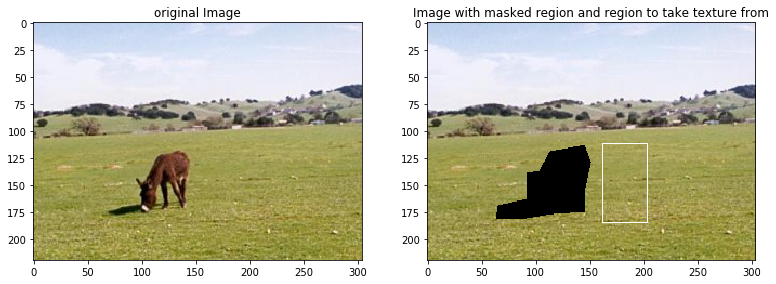

In [4]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os.path

from scipy import stats

# DEPRECATED
# from scipy.misc import imread
# Import PIL or use imread from other packages
from matplotlib.pyplot import imread

plt.rcParams["figure.figsize"] = (20,20)

import utils as utls

def compute_ssd(patch, mask, texture, patch_half_size):
    # For all possible locations of patch in texture_img, computes sum square
    # difference for all pixels where mask = 0
    #
    # Inputs:
    #   patch: numpy array of size (2 * patch_half_size + 1, 2 * patch_half_size + 1, 3)
    #   mask: numpy array of size (2 * patch_half_size + 1, 2 * patch_half_size + 1)
    #   texture: numpy array of size (tex_rows, tex_cols, 3)
    #
    # Outputs:
    #   ssd: numpy array of size (tex_rows - 2 * patch_half_size, tex_cols - 2 * patch_half_size)
    
    patch_rows, patch_cols = np.shape(patch)[0],np.shape(patch)[1]
    
    assert patch_rows == 2 * patch_half_size + 1 and patch_cols == 2 * patch_half_size + 1, "patch size and patch_half_size do not match"
    tex_rows, tex_cols = np.shape(texture)[0], np.shape(texture)[1]
    ssd_rows = tex_rows - 2 * patch_half_size
    ssd_cols = tex_cols - 2 * patch_half_size
    ssd = np.zeros((ssd_rows, ssd_cols))
    
    patch[mask] = [0,0,0]
    
    # Loop center point  of SSD in texture
    for center_i in range(patch_half_size, tex_rows - patch_half_size):
        for center_j in range(patch_half_size, tex_cols - patch_half_size):
            
            tmp_texture = np.array(texture[center_i - patch_half_size:center_i + patch_half_size + 1, 
                                           center_j - patch_half_size:center_j + patch_half_size + 1])
            tmp_texture[mask] = [0,0,0]
            
            ssd[center_i-patch_half_size, center_j-patch_half_size] = ((tmp_texture - patch)**2).sum()
            
            # contains big values and zeros (we want the smallest of the big values)
            
    # Question: if we set to 0, we don't ignore the values of the mask but we reduce it... 
    
    return ssd


#
# Constants
#

# Change patch_half_size to change the patch size used (patch size is 2 * patch_half_size + 1)
patch_half_size = 10
patchSize = 2 * patch_half_size + 1
getnicepicturesforthereport = False

# It is said that if getnicepicturesforthereport is set to True, it will take 3 years to run

# Display results interactively
showResults = True

# Read input image

filename = './img/donkey'
#filename = './img/tomato'
# filename = './img/yacht'

# load image
im_array = imread(filename + '.jpg')#, mode='RGB')
imRows, imCols, imBands = np.shape(im_array)

# load fill region mask
fill_region = imread(filename + '_fill.png')

# load texture mask
texture_region = imread(filename + '_texture.png')

# prepare to display the first 2 subplots of the output
if showResults:
    plt.subplot(1,3,1)
    plt.imshow(im_array)
    plt.title('original Image')

    # create an image with the masked region blacked out, and a rectangle indicating where to
    # fill it from
    im_mask_fill = np.copy(im_array)
    im_mask_fill[np.where(fill_region)] = [0, 0, 0] #blacks out the donkey
    texture_outline = utls.find_edge(texture_region) 
    im_mask_fill[np.where(texture_outline)] = [255, 255, 255] # white border of texture region

    # show it
    plt.subplot(1,3,2)
    plt.imshow(im_mask_fill)
    plt.title('Image with masked region and region to take texture from')

#
# Get coordinates for masked region and texture regions
#
fill_indices = fill_region.nonzero() #2d indexes of pixels to fill 
assert((min(fill_indices[0]) >= patch_half_size) and
        (max(fill_indices[0]) < imRows - patch_half_size) and
        (min(fill_indices[1]) >= patch_half_size) and
        (max(fill_indices[1]) < imCols - patch_half_size)), "Masked region is too close to the edge of the image for this patch size"

texture_indices = texture_region.nonzero() #2d indexes of texture to take 
# Rectangle of texture taken from the image
texture_img = im_array[min(texture_indices[0]):max(texture_indices[0]) + 1,
                        min(texture_indices[1]):max(texture_indices[1]) + 1, :] 
assert((texture_img.shape[0] > patchSize) and
        (texture_img.shape[1] > patchSize)), "Texture region is smaller than patch size"




#
# Initialize im_filled for texture synthesis (i.e., set fill pixels to 0)
#
im_filled = im_array.copy()
im_filled[fill_indices] = 0

#
# Fill the masked region
#

# While there are pixels in the fill_indices 
while (len(fill_indices[0])  > 0):
    print("Number of pixels remaining = ", len(fill_indices[0]) )

    # Set fill_region_edge to pixels on the boundary of the current fill_region
    fill_region_edge = utls.find_edge(fill_region)
    
    edge_pixels = fill_region_edge.nonzero()
    
    while(len(edge_pixels[0]) > 0):
        l = len(edge_pixels[0])
        rand = random.randint(0,l-1)
        patch_center_i, patch_center_j = edge_pixels[0][rand] , edge_pixels[1][rand]
        
        ###########################################################################
        # Had to do a copy because of random modifications on the im_filled image
        # Not sure what caused it but if you replace tmp with im_filled, two lines are replaced with 0s in im_filled
        # if you read this and have any idea, I'd like to understand
        
        #patch_to_fill = im_filled[patch_center_i-patch_half_size:patch_center_i+patch_half_size+1,patch_center_j-patch_half_size:patch_center_j+patch_half_size+1]
        
        tmp = np.copy(im_filled)
        patch_to_fill = tmp[patch_center_i-patch_half_size:patch_center_i+patch_half_size+1,
                            patch_center_j-patch_half_size:patch_center_j+patch_half_size+1]
        patch_mask = np.where(np.all(patch_to_fill == [0,0,0], axis=-1), 0, 1 )
        
        
        #
        # Compute masked SSD of patch_to_fill and texture_img
        #
        ssd_img = compute_ssd(patch_to_fill, patch_mask, texture_img, patch_half_size)
        min_ssd = np.where(ssd_img == np.amin(ssd_img))
        selected_center_i, selected_center_j = min_ssd[0][0], min_ssd[1][0]
        
        #
        # Copy patch into masked region
        #
        im_filled = utls.copy_patch(im_filled, patch_mask, texture_img, 
                                    patch_center_i, patch_center_j, 
                                    selected_center_i, selected_center_j, 
                                    patch_half_size)
        
        if(getnicepicturesforthereport):
            show(fill_region_edge, "Fill region edge before update")
        fill_region_edge[patch_center_i-patch_half_size:patch_center_i+patch_half_size+1,
                         patch_center_j-patch_half_size:patch_center_j+patch_half_size+1] = 0
        if(getnicepicturesforthereport):
            show(fill_region_edge, "Fill region edge after update")
        
        # update edge pixels
        edge_pixels = fill_region_edge.nonzero()
        
    
    if(getnicepicturesforthereport):
        show(fill_region, "Fill region before update")
      
    fill_region[patch_center_i-patch_half_size:patch_center_i+patch_half_size+1,
                patch_center_j-patch_half_size:patch_center_j+patch_half_size+1] = 0
    if(getnicepicturesforthereport):
        show(fill_region, "Fill region after update")
    
    fill_indices = fill_region.nonzero()

#
# Output results
#
if showResults:
    plt.subplot(1,3,3)
    plt.imshow(im_filled)
    plt.title('Filled Image')
    
    plt.show()
